# Statistical Modelling
### Random Forest and CNN
1. Feature Selection
2. Use 2022 April as Test Data
3. Modelling
4. Hyper Parameter Tuning

In [1]:
from pyspark.sql.functions import to_timestamp, date_format, hour, dayofweek
from pyspark.sql.functions import isnan, when, count, col, split, concat, lit
from pyspark.sql.functions import to_date, create_map
from itertools import chain
from pyspark.sql import SparkSession, Window, functions as F
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
from datetime import datetime
import folium
import matplotlib.pyplot as plt
%matplotlib inline

# statistical model
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from statsmodels.formula.api import ols, glm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# train data 2018-2019
df = pd.read_parquet("../data/curated/merged_df.parquet")
df['pu_date'] = pd.to_datetime(df['pu_date'])
df = df.sort_values(by=['pu_date', 'pu_hour']).reset_index(drop=True)

df['pu_day'] = df['pu_date'].dt.day
df['pu_month'] = df['pu_date'].dt.month
df.drop('pu_date', axis=1, inplace=True)

# test data Jan 2020
df_test = pd.read_parquet("../data/curated/merged_test_df.parquet")
df_test['pu_date'] = pd.to_datetime(df_test['pu_date'])
df_test = df_test.sort_values(by=['pu_date', 'pu_hour']).reset_index(drop=True)

df_test['pu_day'] = df_test['pu_date'].dt.day
df_test['pu_month'] = df_test['pu_date'].dt.month
df_test.drop('pu_date', axis=1, inplace=True)

---
## Standardize Data

In [3]:
df.head()

,pu_hour,pu_dow,is_school_holiday,trip_freq,temperature,dew_point,precipitation,wind_direction,visibility,pressure,pu_day,pu_month
0,0,2,1,240,-114.3,-200.300000,0.0,315.000000,16046.5,10260.5,1,1
1,1,2,1,141,-117.5,-206.500000,0.0,330.000000,16093.0,10262.0,1,1
2,2,2,1,33,-122.5,-200.500000,0.0,310.000000,16093.0,10262.0,1,1
3,3,2,1,26,-122.3,-197.300000,0.0,310.000000,16046.5,10262.5,1,1
4,4,2,1,50,-124.5,-198.233333,0.0,316.666667,16093.0,10262.0,1,1


In [4]:
std_col = ['temperature', 'dew_point', 'precipitation', 
           'wind_direction', 'visibility', 'pressure']
df_standard = df[std_col].astype(float).apply(zscore)

df_test_standard = df_test[std_col].astype(float).apply(zscore)

In [5]:
df_test_standard.shape

(744, 6)

In [6]:
df_standard.shape

(17518, 6)

In [7]:
df_standard.describe().loc[['mean','std']]

,temperature,dew_point,precipitation,wind_direction,visibility,pressure
mean,4.964823e-16,-6.691822e-16,-4.015543e-16,-6.655729e-16,1.995017e-16,-5.256213e-15
std,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00


In [8]:
df_standard.head()

,temperature,dew_point,precipitation,wind_direction,visibility,pressure
0,-2.482008,-2.431581,-0.213048,1.203785,0.373931,1.119520
1,-2.515051,-2.486621,-0.213048,1.355128,0.386613,1.137956
2,-2.566679,-2.433356,-0.213048,1.153337,0.386613,1.137956
3,-2.564614,-2.404948,-0.213048,1.153337,0.373931,1.144101
4,-2.587330,-2.413234,-0.213048,1.220601,0.386613,1.137956


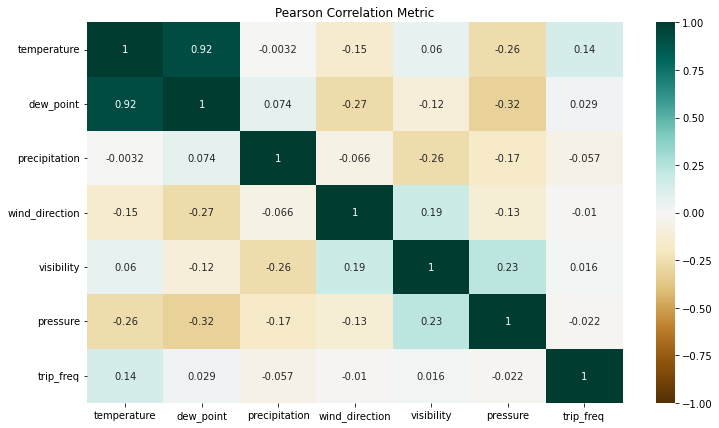

In [9]:
plt.figure(figsize=(12,7))
sns.heatmap(pd.concat([df_standard, df[['trip_freq']]], axis=1).corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

plt.title('Pearson Correlation Metric')
plt.show()

In [10]:
df_fit = pd.concat([df_standard, df[['trip_freq']]], axis=1)
# let's try another model with all weather features
fit = ols(
    formula="trip_freq ~ temperature + dew_point + precipitation + wind_direction + visibility + pressure",
    data=df_fit
).fit()

In [11]:
# let's try another model without dew_point
fitter = ols(
    formula="trip_freq ~ temperature + precipitation + wind_direction + visibility + pressure",
    data=df_fit
).fit()

In [12]:
# let's try another model without temperature
fitter1 = ols(
    formula="trip_freq ~ dew_point + precipitation + wind_direction + visibility + pressure",
    data=df_fit
).fit()

In [13]:
fit.aic, fitter.aic, fitter1.aic

(252980.61726486217, 254391.3041391059, 254699.9893976533)

As Temperature and Dew point are very highly correlated, it is as expected that we should remove one of them to minimise complexity in the model. Using the AIC score, it is obvious that the model without dew_point has the lowest AIC. Hence, moving forward we will remove this feature.


In [14]:
valid_col = ["temperature", "precipitation", "wind_direction", "visibility", "pressure"]
df_standard = df_standard[valid_col]
df_test_standard = df_test_standard[valid_col]

---
## One-hot encode categorical variable

In [15]:
x_col = ['pu_hour', 'pu_dow', 'pu_day', 'pu_month']

enc = pd.get_dummies(df['pu_hour'], prefix='pu_hour')
for feature in x_col[1:]:
    df_feat = pd.get_dummies(df[feature], prefix=feature)
    enc = pd.concat([enc, df_feat], axis=1)

test_enc = pd.get_dummies(df_test['pu_hour'], prefix='pu_hour')
for feature in x_col[1:]:
    df_feat = pd.get_dummies(df_test[feature], prefix=feature)
    test_enc = pd.concat([test_enc, df_feat], axis=1)
for m in range(2, 13):
    test_enc[f'pu_month_{str(m)}'] = 0


In [16]:
enc.shape

(17518, 74)

In [17]:
test_enc.shape

(744, 74)

In [18]:
test_enc.columns

Index(['pu_hour_0', 'pu_hour_1', 'pu_hour_2', 'pu_hour_3', 'pu_hour_4',
       'pu_hour_5', 'pu_hour_6', 'pu_hour_7', 'pu_hour_8', 'pu_hour_9',
       'pu_hour_10', 'pu_hour_11', 'pu_hour_12', 'pu_hour_13', 'pu_hour_14',
       'pu_hour_15', 'pu_hour_16', 'pu_hour_17', 'pu_hour_18', 'pu_hour_19',
       'pu_hour_20', 'pu_hour_21', 'pu_hour_22', 'pu_hour_23', 'pu_dow_1',
       'pu_dow_2', 'pu_dow_3', 'pu_dow_4', 'pu_dow_5', 'pu_dow_6', 'pu_dow_7',
       'pu_day_1', 'pu_day_2', 'pu_day_3', 'pu_day_4', 'pu_day_5', 'pu_day_6',
       'pu_day_7', 'pu_day_8', 'pu_day_9', 'pu_day_10', 'pu_day_11',
       'pu_day_12', 'pu_day_13', 'pu_day_14', 'pu_day_15', 'pu_day_16',
       'pu_day_17', 'pu_day_18', 'pu_day_19', 'pu_day_20', 'pu_day_21',
       'pu_day_22', 'pu_day_23', 'pu_day_24', 'pu_day_25', 'pu_day_26',
       'pu_day_27', 'pu_day_28', 'pu_day_29', 'pu_day_30', 'pu_day_31',
       'pu_month_1', 'pu_month_2', 'pu_month_3', 'pu_month_4', 'pu_month_5',
       'pu_month_6', 'pu_month_7', 

In [19]:
enc.columns

Index(['pu_hour_0', 'pu_hour_1', 'pu_hour_2', 'pu_hour_3', 'pu_hour_4',
       'pu_hour_5', 'pu_hour_6', 'pu_hour_7', 'pu_hour_8', 'pu_hour_9',
       'pu_hour_10', 'pu_hour_11', 'pu_hour_12', 'pu_hour_13', 'pu_hour_14',
       'pu_hour_15', 'pu_hour_16', 'pu_hour_17', 'pu_hour_18', 'pu_hour_19',
       'pu_hour_20', 'pu_hour_21', 'pu_hour_22', 'pu_hour_23', 'pu_dow_1',
       'pu_dow_2', 'pu_dow_3', 'pu_dow_4', 'pu_dow_5', 'pu_dow_6', 'pu_dow_7',
       'pu_day_1', 'pu_day_2', 'pu_day_3', 'pu_day_4', 'pu_day_5', 'pu_day_6',
       'pu_day_7', 'pu_day_8', 'pu_day_9', 'pu_day_10', 'pu_day_11',
       'pu_day_12', 'pu_day_13', 'pu_day_14', 'pu_day_15', 'pu_day_16',
       'pu_day_17', 'pu_day_18', 'pu_day_19', 'pu_day_20', 'pu_day_21',
       'pu_day_22', 'pu_day_23', 'pu_day_24', 'pu_day_25', 'pu_day_26',
       'pu_day_27', 'pu_day_28', 'pu_day_29', 'pu_day_30', 'pu_day_31',
       'pu_month_1', 'pu_month_2', 'pu_month_3', 'pu_month_4', 'pu_month_5',
       'pu_month_6', 'pu_month_7', 

---
### Combine the standardized continuous features and one-hot encoded ordinal features into one dataframe

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17518 entries, 0 to 17517
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pu_hour            17518 non-null  int32  
 1   pu_dow             17518 non-null  int32  
 2   is_school_holiday  17518 non-null  int32  
 3   trip_freq          17518 non-null  int64  
 4   temperature        17518 non-null  float64
 5   dew_point          17518 non-null  float64
 6   precipitation      17518 non-null  float64
 7   wind_direction     17518 non-null  float64
 8   visibility         17518 non-null  float64
 9   pressure           17518 non-null  float64
 10  pu_day             17518 non-null  int64  
 11  pu_month           17518 non-null  int64  
dtypes: float64(6), int32(3), int64(3)
memory usage: 1.4 MB


In [21]:
X_train = pd.concat([df_standard, enc, df[['is_school_holiday']]], axis=1)
X_test = pd.concat([df_test_standard, test_enc, df_test[['is_school_holiday']]]
                   , axis=1)

In [22]:
X_train.shape, X_test.shape

((17518, 80), (744, 80))

In [23]:
scaler_y_train = StandardScaler().fit(df[['trip_freq']])
y_train = np.ravel(scaler_y_train.transform(df[['trip_freq']]))

scaler_y_test = StandardScaler().fit(df_test[['trip_freq']])
y_test = np.ravel(scaler_y_test.transform(df_test[['trip_freq']]))


---
# Logistic Regression (base model)

---
# Random Forest Modelling
Use Random Forest as it is able to capture complex decision boundaries relationship between features.

### Hyperparameter Tuning (max_feature and n_estimator)

In [81]:
for mf in ("sqrt", "log2", None):
    rf = RandomForestRegressor(random_state = 42, max_features=mf)
    r2_cv = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    print(f"max_feature = {mf}: \t", np.mean(r2_cv))

max_feature = sqrt: 	 0.8297925493735934
max_feature = log2: 	 0.8238667661334537
max_feature = None: 	 0.8121274773129613
max_feature = 20: 	 0.8260103457111689
max_feature = 50: 	 0.8156384064702664


When max_feature = sqrt, the model has best r2 score. This shows how much data, the model can understand.

In [84]:
for n_est in (10, 100, 300, 500, 800, 1000):
    rf = RandomForestRegressor(n_estimators=n_est, random_state = 42, max_features='sqrt')
    r2_cv = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    print(f"n_estimators = {n_est}: \t", np.mean(r2_cv))

n_estimators = 10: 	 0.8090362167047231
n_estimators = 100: 	 0.8297925493735934
n_estimators = 300: 	 0.8307275345023533
n_estimators = 500: 	 0.8310377006235043
n_estimators = 800: 	 0.8310738299222729
n_estimators = 1000: 	 0.8311210047557747


When n_estimators = 1000, the model has best r2 score. But, if we look deeper, the increase in r2 score is not that significant after n_estimator = 500. So we pick n_estimator = 500.

In [92]:
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score

In [86]:
rf = RandomForestRegressor(n_estimators = 500, max_features='sqrt', random_state = 42)
rf.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=500, random_state=42)

### Prediction

In [87]:
predictions = rf.predict(X_test)

In [88]:
errors = abs(predictions - y_test)

In [126]:
errors = abs(predictions - y_test)
mae = round(np.mean(errors), 2)
mape = np.mean(100 * (errors / y_test))
accuracy = round(100 - mape, 2)
r2 = round(r2_score(y_test, predictions), 2)

print('Mean Absolute Error:', mae)
print('Accuracy:', accuracy)
print('R^2 Score:', r2)


Mean Absolute Error: 0.27
Accuracy: 88.94
R^2 Score: 0.87


### Prediction vs Actual Visualization

In [127]:
y_pred = pd.DataFrame({'pred_trip_freq':predictions})

In [128]:
y_pred_actual = np.ravel(scaler_y_test.inverse_transform(y_pred))

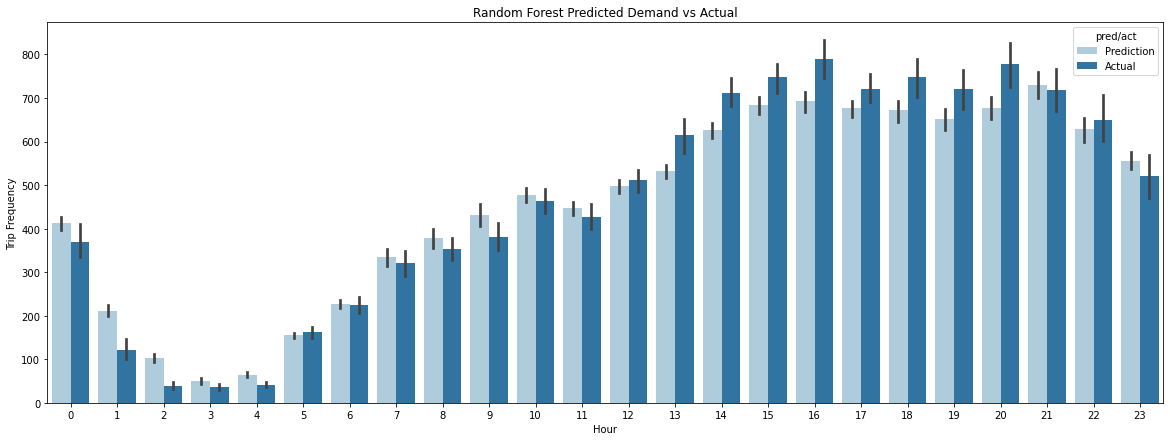

In [132]:
df1 = pd.DataFrame({'trip_freq':y_pred_actual})
df1['pu_hour'] = df_test['pu_hour']
df1['pu_day'] = df_test['pu_day']
df1['pred/act'] = 'Prediction'

df2 = df_test[['pu_hour', 'pu_day', 'trip_freq']]
df2['pred/act'] = 'Actual'

df_visualise = pd.concat([df1, df2],axis=0)

plt.figure(figsize=(20, 7))
sns.barplot(
    x="pu_hour", y="trip_freq", hue="pred/act", data=df_visualise, ci=95, 
    palette="Paired"
)
plt.xlabel("Hour")
plt.ylabel("Trip Frequency")
plt.title("Random Forest Predicted Demand vs Actual")
plt.show()



Interestingly, the model is very optimistic during the morning peaks, and appears to have become more pessimistic after noon.

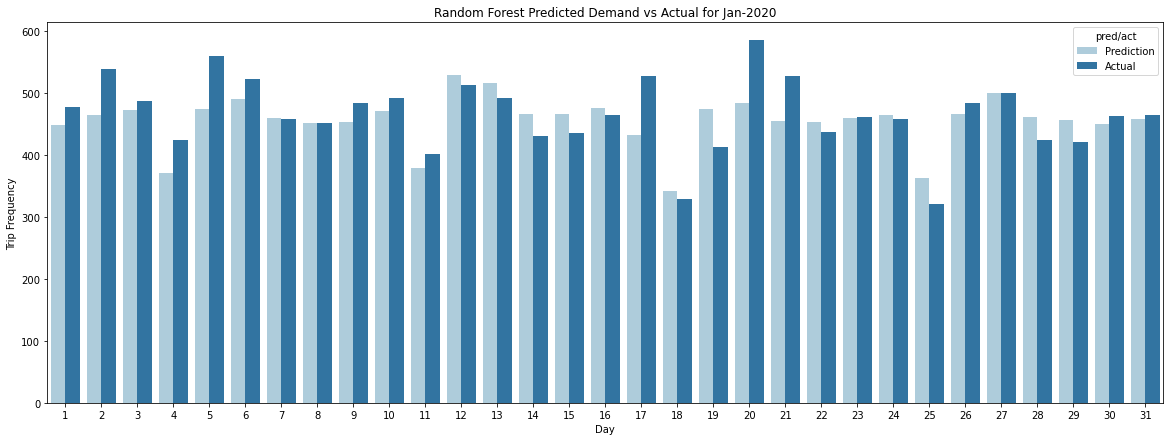

In [130]:
plt.figure(figsize=(20,7))
sns.barplot(
    x="pu_day", y="trip_freq", hue="pred/act", data=df_visualise, ci=None,
    palette="Paired"
)
plt.xlabel("Day")
plt.ylabel("Trip Frequency")
plt.title("Random Forest Predicted Demand vs Actual for Jan-2020")
plt.show()

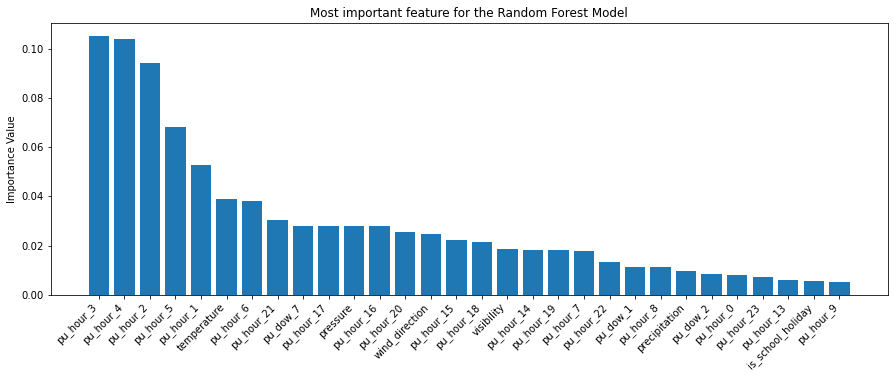

In [131]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
df_imp = (pd.DataFrame({'feature':X_train.columns.tolist(), 'importances':importances})
            .sort_values(by='importances', ascending=False).reset_index(drop=True))

df_imp_top30 = df_imp[:30]
plt.figure(figsize=(15,5))
plt.bar('feature', 'importances', orientation = 'vertical', data=df_imp_top30)
plt.xticks(rotation=45, ha="right")
plt.xlabel("")
plt.ylabel("Importance Value")
plt.title("Most important feature for the Random Forest Model")
plt.show()